<a href="https://colab.research.google.com/github/Anitha-Maligireddy/Energy-Consumption/blob/main/energy_analysis_fPf21mrwQw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import all the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [5]:
# Load dataset
df = pd.read_csv("solar_iot.csv", parse_dates=['timestamp'])
#df

Index(['Ride_ID', 'Timestamp', 'GPS_Location', 'Speed_kmph',
       'Acceleration_mps2', 'Gyroscope_Rotation_rad_s', 'Engine_Status',
       'Brake_Event', 'Seatbelt_Status', 'Door_Status',
       'Fuel_or_Battery_Level_%', 'Ambient_Noise_dB'],
      dtype='object')


In [7]:
# Extract time features
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['weekday'] = df['timestamp'].dt.dayofweek
df['date'] = df['timestamp'].dt.date
#df

KeyError: 'timestamp'

In [ ]:
# Basic summary
print("=== Basic Info ===")
print(df.info())

=== Basic Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   timestamp            50 non-null     datetime64[ns]
 1   temperature          50 non-null     float64       
 2   outside_temperature  50 non-null     float64       
 3   device_usage         50 non-null     int64         
 4   energy_consumption   50 non-null     float64       
 5   hour                 50 non-null     int32         
 6   day                  50 non-null     int32         
 7   weekday              50 non-null     int32         
 8   date                 50 non-null     object        
dtypes: datetime64[ns](1), float64(3), int32(3), int64(1), object(1)
memory usage: 3.1+ KB
None


In [ ]:
print("\n=== Summary ===")
print(df.describe())


=== Summary ===
                           timestamp  temperature  outside_temperature  \
count                             50    50.000000             50.00000   
mean   2025-07-02 00:29:59.999999744    25.310800             32.44260   
min              2025-07-01 00:00:00    20.160000             25.10000   
25%              2025-07-01 12:15:00    22.792500             28.76500   
50%              2025-07-02 00:30:00    25.290000             31.99000   
75%              2025-07-02 12:45:00    27.500000             35.93500   
max              2025-07-03 01:00:00    29.770000             39.94000   
std                              NaN     2.809494              4.47634   

       device_usage  energy_consumption      hour        day    weekday  
count     50.000000           50.000000  50.00000  50.000000  50.000000  
mean       0.520000            2.944800  11.06000   1.560000   1.560000  
min        0.000000            1.150000   0.00000   1.000000   1.000000  
25%        0.000000 

In [ ]:
# Daily and Weekly Consumption Analysis
daily_consumption = df.groupby('date')['energy_consumption'].sum()
weekly_consumption = df.groupby(df['timestamp'].dt.isocalendar().week)['energy_consumption'].sum()

In [ ]:
print("\n=== Daily Consumption (First 5 Days) ===")
print(daily_consumption.head())


=== Daily Consumption (First 5 Days) ===
date
2025-07-01    67.46
2025-07-02    72.62
2025-07-03     7.16
Name: energy_consumption, dtype: float64


In [ ]:
print("\n=== Weekly Consumption (First 5 Weeks) ===")
print(weekly_consumption.head())


=== Weekly Consumption (First 5 Weeks) ===
week
27    147.24
Name: energy_consumption, dtype: float64


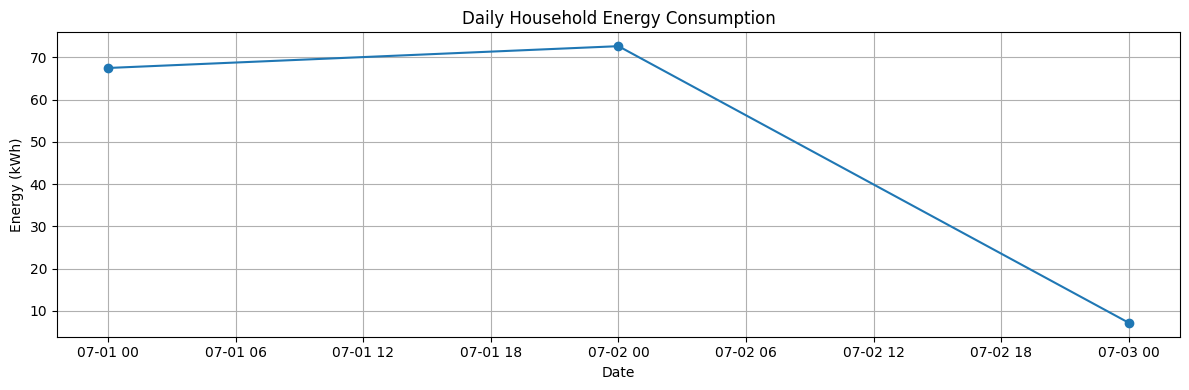

In [ ]:
# Visualize Daily Usage
plt.figure(figsize=(12, 4))
plt.plot(daily_consumption.index, daily_consumption.values, marker='o')
plt.title("Daily Household Energy Consumption")
plt.xlabel("Date")
plt.ylabel("Energy (kWh)")
plt.grid(True)
plt.tight_layout()
plt.savefig("daily_energy_plot.png")
plt.show()

In [ ]:
# Forecasting with Linear Regression
features = ['temperature', 'outside_temperature', 'device_usage', 'hour', 'weekday']
X = df[features]
y = df['energy_consumption']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
joblib.dump(model, "forecast_model.pkl")

['forecast_model.pkl']

In [ ]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\nForecasting RMSE: {rmse:.3f}")
# RMSE (Root Mean Square Error) is a statistical measure that represents the square root of the average squared differences between predicted and observed outcomes.
# It provides an indication of how well the model is performing, with lower values indicating better performance.



Forecasting RMSE: 0.700


In [ ]:
# Add forecast to full dataset
df['predicted_consumption'] = model.predict(X)

In [ ]:
# Detect inefficiencies: consumption 25% higher than moving avg (6-hour window)
df['moving_avg'] = df['energy_consumption'].rolling(window=6, min_periods=1).mean()
df['inefficient'] = df['energy_consumption'] > 1.25 * df['moving_avg']

In [ ]:
print("\n=== Inefficient Usage Entries ===")
ineff_df = df[df['inefficient']]
print(ineff_df[['timestamp', 'energy_consumption', 'moving_avg']].head())


=== Inefficient Usage Entries ===
             timestamp  energy_consumption  moving_avg
2  2025-07-01 02:00:00                3.21    2.436667
6  2025-07-01 06:00:00                3.46    2.581667
8  2025-07-01 08:00:00                3.49    2.675000
12 2025-07-01 12:00:00                3.88    2.911667
19 2025-07-01 19:00:00                4.59    2.880000


In [ ]:
# Recommendation Engine (Simple Rules)
recommendations = []

for _, row in ineff_df.iterrows():
    if row['device_usage'] > 0 and row['energy_consumption'] > 3:
        recommendations.append("Consider turning off idle devices during high-usage periods.")
    if row['outside_temperature'] > 30 and row['energy_consumption'] > 3:
        recommendations.append("High outside temp + high usage: Adjust thermostat or close blinds.")
    if row['hour'] in [0, 1, 2, 3, 4] and row['energy_consumption'] > 2:
        recommendations.append("High energy use detected at night. Investigate appliance usage.")

In [ ]:
recommendations = list(set(recommendations))
print("\n=== Recommendations ===")
for rec in recommendations:
    print(f"- {rec}")


=== Recommendations ===
- High outside temp + high usage: Adjust thermostat or close blinds.
- Consider turning off idle devices during high-usage periods.
- High energy use detected at night. Investigate appliance usage.


In [8]:
import pandas as pd

def analyze_energy_data(file_path):
    """
    Reads a CSV file, displays the first 5 rows, and provides a statistical summary.

    Args:
        file_path (str): The path to the CSV file.
    """
    try:
        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)

        print("Data loaded successfully.")
        print("\nFirst 5 rows of the dataset:")
        print(df.head())

        print("\nStatistical summary of the dataset:")
        print(df.describe())

        print("\nData types and non-null values:")
        print(df.info())

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    # You can change the file path here to match where you saved your CSV file.
    # For this example, we assume the file is in the same directory as the script.
    csv_file_path = "solar_iot_energy_data_AZrAL5DeeQ.csv"
    analyze_energy_data(csv_file_path)

Data loaded successfully.

First 5 rows of the dataset:
          Timestamp  Panel_ID  Solar_Irradiance_W/m2  Panel_Temperature_C  \
0  2025-08-01 08:00  SOLAR001                    927                 38.6   
1  2025-08-01 08:15  SOLAR001                    953                 44.7   
2  2025-08-01 08:30  SOLAR001                    982                 40.3   
3  2025-08-01 08:45  SOLAR001                    896                 41.6   
4  2025-08-01 09:00  SOLAR001                    866                 41.7   

   Ambient_Temperature_C  Voltage_V  Current_A  Power_Output_W  \
0                     35       48.1       5.48           263.6   
1                     31       47.7       5.23           249.5   
2                     32       47.3       5.40           255.4   
3                     33       49.1       5.01           246.0   
4                     31       47.2       5.35           252.5   

   Battery_Charge_Level_%  Load_Consumption_W  Grid_Usage_W  Energy_Saved_kWh  \
0  

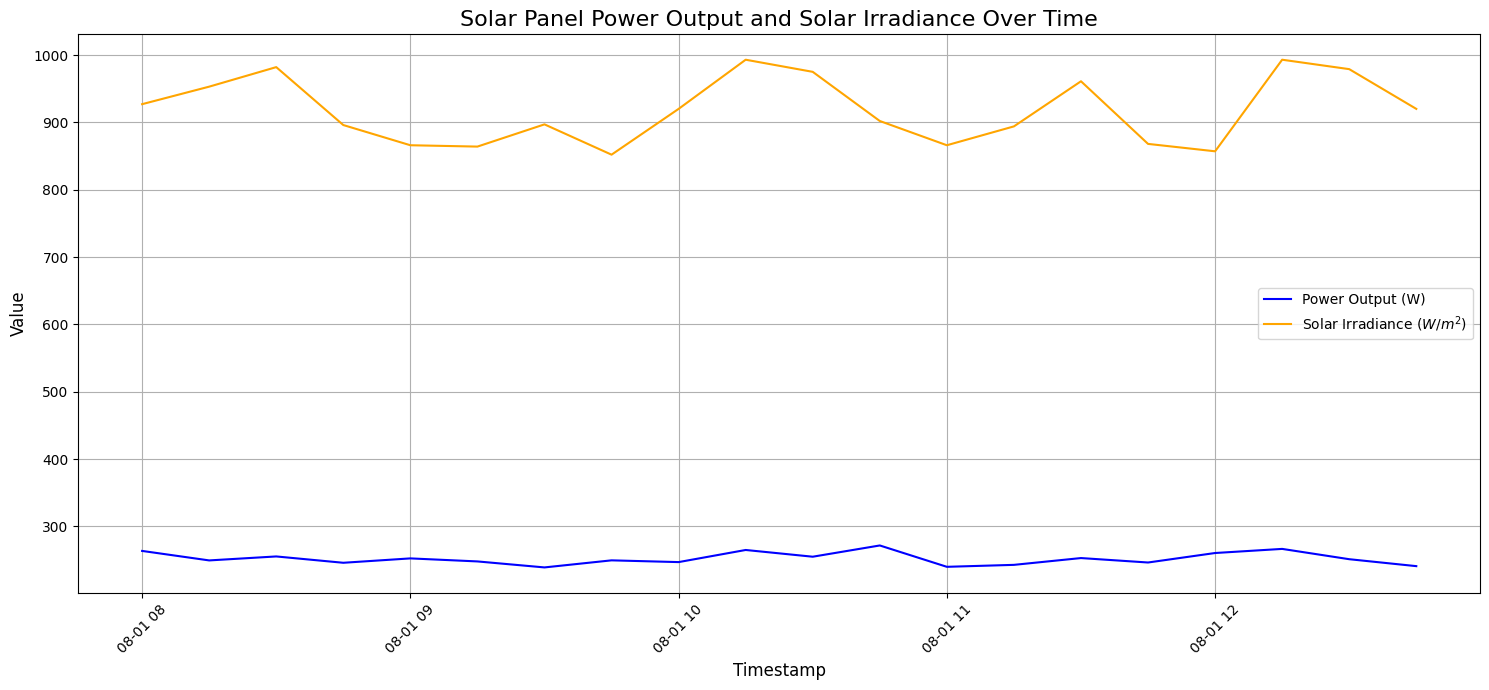

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("solar_iot_energy_data_AZrAL5DeeQ.csv")

# Convert the 'Timestamp' column to datetime objects
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Set the timestamp as the index for plotting
df.set_index('Timestamp', inplace=True)

# Create a figure and axis object
plt.figure(figsize=(15, 7))

# Plot 'Power_Output_W' and 'Solar_Irradiance_W/m2'
plt.plot(df.index, df['Power_Output_W'], label='Power Output (W)', color='blue')
plt.plot(df.index, df['Solar_Irradiance_W/m2'], label='Solar Irradiance ($W/m^2$)', color='orange')

# Set plot title and labels
plt.title('Solar Panel Power Output and Solar Irradiance Over Time', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Save the plot to a file
plt.savefig('solar_panel_performance.png')